# WasteNet
Author: Mengtian Li, Yanqi Liu

Date:04/28/2021

In [ ]:
!pip install split-folders
!pip install torchcam

In [ ]:
# imports
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display
from torch.autograd import Variable
from torchcam.cams import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image


from tqdm.notebook import tqdm, trange
from time import sleep
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy


# Preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/Shareddrives/CIS 522 project/trashnet-data/dataset-resized.zip'

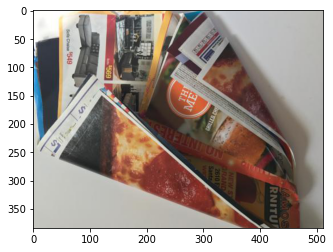

In [ ]:
image = plt.imread('dataset-resized/paper/paper99.jpg')
plt.imshow(image)

In [ ]:
image.shape

(384, 512, 3)

In [ ]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
WASTE_DICT = {
  'glass': 1,
  'paper': 2,
  'cardboard': 3,
  'plastic': 4,
  'metal': 5,
  'trash': 6 
}

In [ ]:
WASTE_DICT_REV = {
1 : 'glass',
2 : 'paper',
3 : 'cardboard',
4 : 'plastic',
5 : 'metal',
6 : 'trash'
}

In [ ]:
splitfolders.ratio('dataset-resized', output="waste_root_dir", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 2527 files [00:00, 6682.04 files/s]


# Non DL method: SVM

## Prepare Data for training and testing

In [ ]:
X = []
y = []
for subdir in os.listdir('dataset-resized'):
  if (subdir in WASTE_DICT.keys()):
    current_path = os.path.join('dataset-resized', subdir)

    for file in os.listdir(current_path):
        if file[-3:] in {'jpg', 'png'}:
            im = plt.imread(os.path.join(current_path, file))
            y.append(WASTE_DICT[subdir])
            X.append(im)

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

## Data preprocessing

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.color import rgb2gray 
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.pipeline import Pipeline
from sklearn import svm

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2021, 32760)


In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

## Training with linear SVM

In [ ]:
svm_clf = svm.LinearSVC()
svm_clf.fit(X_train_prepared, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Training Accuracy

In [ ]:
y_train_pred = svm_clf.predict(X_train_prepared)
print('Percentage correct: ', 100*np.sum(y_train_pred == y_train)/len(y_train))

Percentage correct:  99.95051954477981


## Test Accuracy

In [ ]:
y_pred = svm_clf.predict(X_test_prepared)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  57.905138339920946


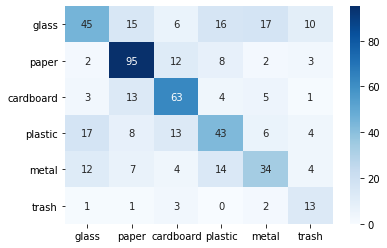

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

# DL methods

## Preprocessing data

### Get mean and max of train dataset

In [ ]:
dataset = ImageFolder('/content/waste_root_dir/train', transform=transforms.ToTensor())
loader = DataLoader(dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

### Data Augmentation

In [ ]:
train_transform = transforms.Compose([
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)])
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)])

In [ ]:
train_data = ImageFolder('waste_root_dir/train', transform=train_transform)
val_data = ImageFolder('waste_root_dir/val', transform=test_transform)
test_data = ImageFolder('waste_root_dir/test', transform=test_transform)

### Data loader

In [ ]:
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=16, drop_last=True)
test_data_loader = DataLoader(test_data, shuffle=True, batch_size=16, drop_last=True)
val_data_loader = DataLoader(val_data, shuffle=True, batch_size=16, drop_last=True)

In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


## AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        # keeps track of the running loss
        running_loss = 0.

        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description(f'Training epoch: {epoch}')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model.forward(data)
                loss = criterion(output, target)
                
                loss.backward()
                optimizer.step()
                # set loss to whatever you end up naming your variable when 
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
      
        train_loss.append(running_loss / total)  # append the loss for this epoch
        train_acc.append(correct/total)
                
        # evaluate on validation data
        
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            with torch.no_grad():
              for data, target in tepoch:
                  data, target = data.to(device), target.to(device)
                  optimizer.zero_grad()
                  output = model.forward(data)
                  
                  loss = criterion(output, target)
                  tepoch.set_postfix(loss=loss.item())
                  running_loss += loss.item()

                  # get accuracy 
                  _, predicted = torch.max(output, 1)
                  total += target.size(0)
                  correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        epoch_acc = correct / total
        validation_acc.append(epoch_acc)
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
    return train_loss, train_acc, validation_loss, validation_acc, model

### Train

In [ ]:
alex_cnn = AlexNet(num_classes=6).to(device)
alex_optimizer = torch.optim.Adam(alex_cnn.parameters())
alex_criterion = nn.CrossEntropyLoss()
num_epochs = 40
alex_train_loss, alex_train_acc, alex_val_loss, alex_val_acc, alex_cnn = train(alex_cnn, device, train_data_loader, val_data_loader, num_epochs, alex_criterion, alex_optimizer)

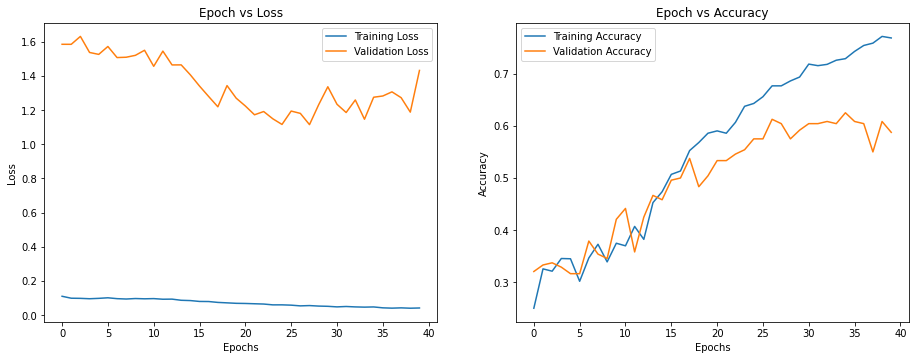

In [ ]:
plot_loss_accuracy(alex_train_loss, alex_train_acc, alex_val_loss, alex_val_acc)

### Test result

Test accuracy is  55.859375


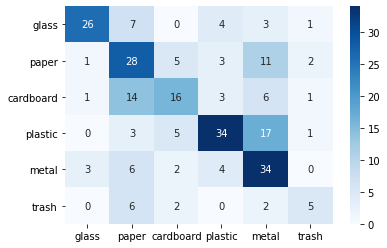

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = alex_cnn(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

### Smooth grad CAM

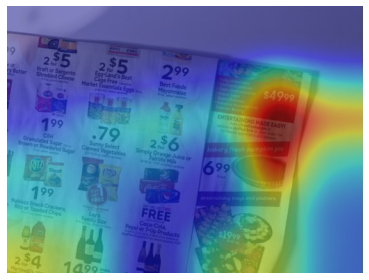

In [ ]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
cam_extractor = SmoothGradCAMpp(alex_cnn)
# Get your input
img = read_image("/content/waste_root_dir/test/paper/paper2.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (384,512)) / 255, mean=mean, std=std)

# Preprocess your data and feed it to the model
out = alex_cnn(input_tensor.unsqueeze(0).to(device))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

## Resnet

### Train

In [ ]:
resnet_18 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18')
resnet_18.eval()

In [ ]:
resnet_18 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18')
resnet_18.fc = nn.Linear(512,6)
resnet_18 = resnet_18.to(device)
resnet_18_optimizer = torch.optim.Adam(resnet_18.parameters())
resnet_18_criterion = nn.CrossEntropyLoss()
num_epochs = 40
resnet_18_train_loss, resnet_18_train_acc, resnet_18_val_loss, resnet_18_val_acc, resnet_18 = train(resnet_18, device, train_data_loader, val_data_loader, num_epochs, resnet_18_criterion, resnet_18_optimizer)

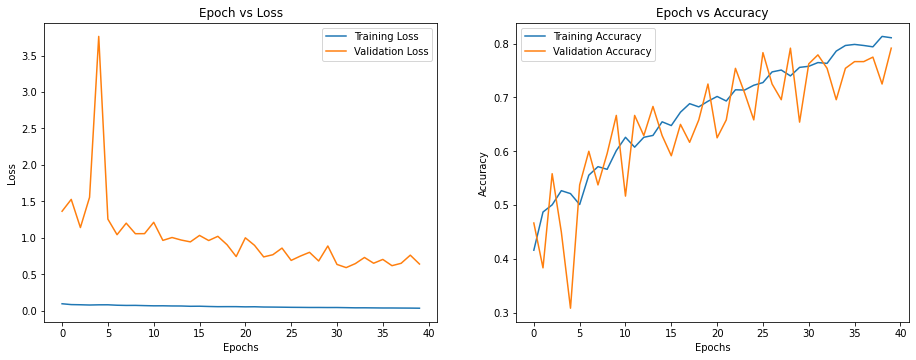

In [ ]:
plot_loss_accuracy(resnet_18_train_loss, resnet_18_train_acc, resnet_18_val_loss, resnet_18_val_acc)

### Test result

Test accuracy is  74.21875


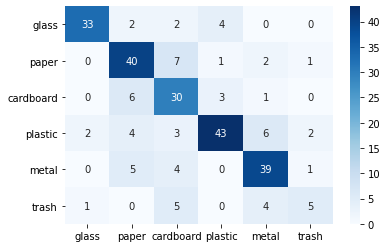

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = resnet_18(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

### Smooth grad CAM

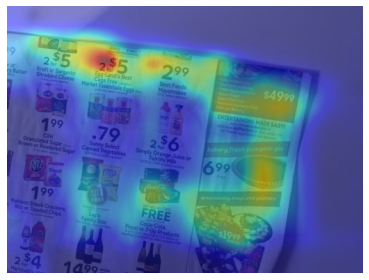

In [ ]:
cam_extractor = SmoothGradCAMpp(resnet_18)
# Get your input
img = read_image("/content/waste_root_dir/test/paper/paper2.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (384,512)) / 255, mean=mean, std=std)

# Preprocess your data and feed it to the model
out = resnet_18(input_tensor.unsqueeze(0).to(device))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

### Resnet with hinge loss

In [ ]:
resnet_18_hinge = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18')

num_ftrs = resnet_18_hinge.fc.in_features
resnet_18_hinge.fc = nn.Linear(num_ftrs, out_features=6)

resnet_18_hinge = resnet_18_hinge.to(device)

resnet_18_hinge_criterion = nn.MultiMarginLoss()
resnet_18_hinge_optimizer = optim.Adam(resnet_18_hinge.fc.parameters())
num_epochs = 40
resnet_18_hinge_train_loss, resnet_18_hinge_train_acc, resnet_18_hinge_val_loss, resnet_18_hinge_val_acc, resnet_18_hinge = train(resnet_18_hinge, device, train_data_loader, val_data_loader, num_epochs, resnet_18_hinge_criterion, resnet_18_hinge_optimizer)

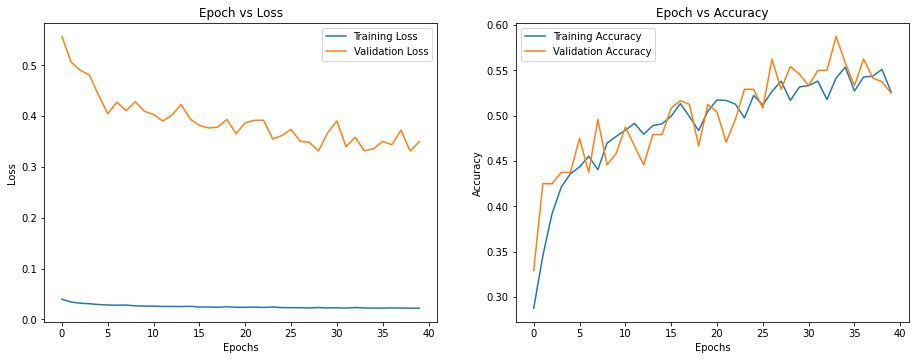

In [ ]:
plot_loss_accuracy(resnet_18_hinge_train_loss, resnet_18_hinge_train_acc, resnet_18_hinge_val_loss, resnet_18_hinge_val_acc)

Test accuracy is  58.984375


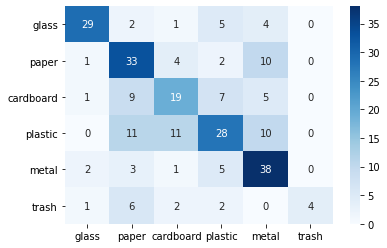

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = resnet_18_hinge(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

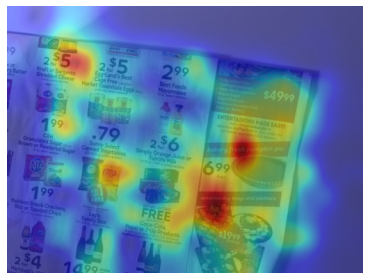

In [ ]:
cam_extractor = SmoothGradCAMpp(resnet_18_hinge)
# Get your input
img = read_image("/content/waste_root_dir/test/paper/paper2.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (384,512)) / 255, mean=mean, std=std)

# Preprocess your data and feed it to the model
out = resnet_18_hinge(input_tensor.unsqueeze(0).to(device))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

## Transfer learning

### Transfer learning from resnet-18 with CE

In [ ]:
resnet_18_pretrained = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
for param in resnet_18_pretrained.parameters():
    param.requires_grad = False

num_ftrs = resnet_18_pretrained.fc.in_features
resnet_18_pretrained.fc = nn.Linear(num_ftrs, out_features=6)

resnet_18_pretrained = resnet_18_pretrained.to(device)

resnet_18_pretrained_criterion = nn.CrossEntropyLoss()
resnet_18_pretrained_optimizer = optim.Adam(resnet_18_pretrained.fc.parameters())
num_epochs = 40
resnet_18_pretrained_train_loss, resnet_18_pretrained_train_acc, resnet_18_pretrained_val_loss, resnet_18_pretrained_val_acc, resnet_18_pretrained = train(resnet_18_pretrained, device, train_data_loader, val_data_loader, num_epochs, resnet_18_pretrained_criterion, resnet_18_pretrained_optimizer)

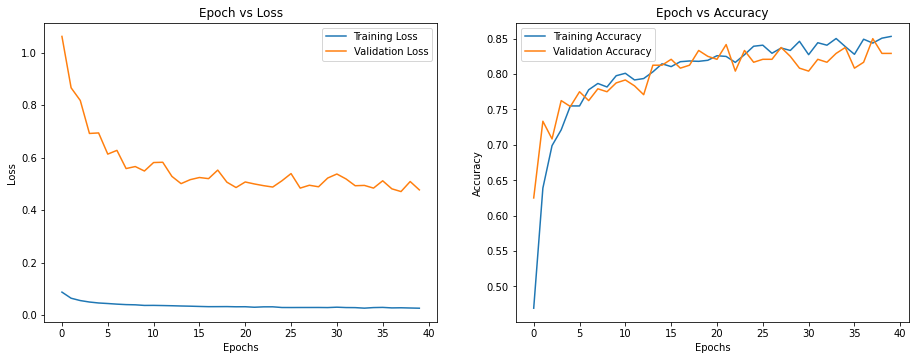

In [ ]:
plot_loss_accuracy(resnet_18_pretrained_train_loss, resnet_18_pretrained_train_acc, resnet_18_pretrained_val_loss, resnet_18_pretrained_val_acc)

Test accuracy is  62.109375


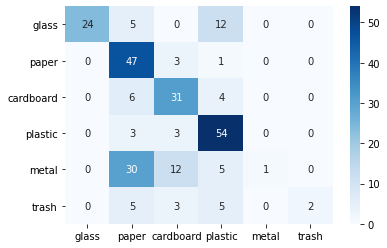

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = resnet_18_pretrained(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

### Transfer learning from resnet-18 with hinge loss

In [ ]:
resnet_18_pretrained_hinge = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
for param in resnet_18_pretrained_hinge.parameters():
    param.requires_grad = False

num_ftrs = resnet_18_pretrained_hinge.fc.in_features
resnet_18_pretrained_hinge.fc = nn.Linear(num_ftrs, out_features=6)

resnet_18_pretrained_hinge = resnet_18_pretrained_hinge.to(device)

resnet_18_pretrained_hinge_criterion = nn.MultiMarginLoss()
resnet_18_pretrained_hinge_optimizer = optim.Adam(resnet_18_pretrained_hinge.fc.parameters())
num_epochs = 40
resnet_18_pretrained_hinge_train_loss, resnet_18_pretrained_hinge_train_acc, resnet_18_pretrained_hinge_val_loss, resnet_18_pretrained_hinge_val_acc, resnet_18_pretrained_hinge = train(resnet_18_pretrained_hinge, device, train_data_loader, val_data_loader, num_epochs, resnet_18_pretrained_hinge_criterion, resnet_18_pretrained_hinge_optimizer)

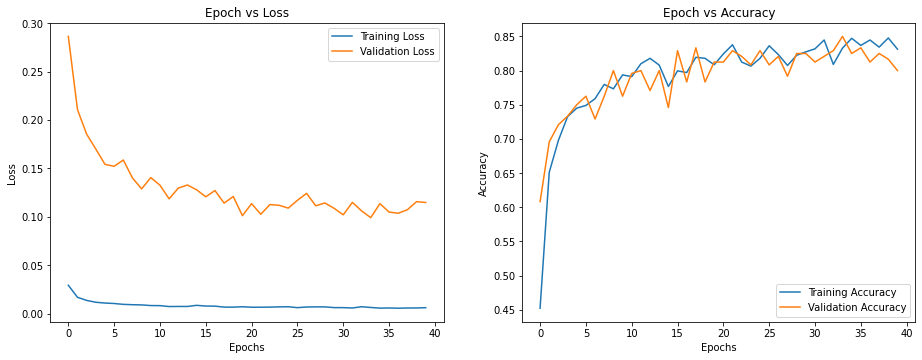

In [ ]:
plot_loss_accuracy(resnet_18_pretrained_hinge_train_loss, resnet_18_pretrained_hinge_train_acc, resnet_18_pretrained_hinge_val_loss, resnet_18_pretrained_hinge_val_acc)

Test accuracy is  84.765625


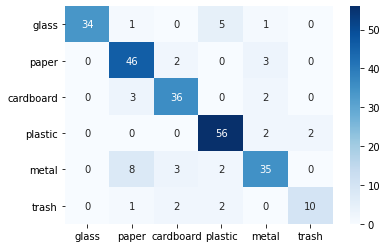

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = resnet_18_pretrained_hinge(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

### Transfer learning from resnet-18 with RMSprop

In [ ]:
resnet_18_pretrained_rmsprop = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
for param in resnet_18_pretrained_rmsprop.parameters():
    param.requires_grad = False

num_ftrs = resnet_18_pretrained_rmsprop.fc.in_features
resnet_18_pretrained_rmsprop.fc = nn.Linear(num_ftrs, out_features=6)

resnet_18_pretrained_rmsprop = resnet_18_pretrained_rmsprop.to(device)

resnet_18_pretrained_rmsprop_criterion = nn.CrossEntropyLoss()
resnet_18_pretrained_rmsprop_optimizer = optim.RMSprop(resnet_18_pretrained_rmsprop.fc.parameters(), )
num_epochs = 40
resnet_18_pretrained_rmsprop_train_loss, resnet_18_pretrained_rmsprop_train_acc, resnet_18_pretrained_rmsprop_val_loss, resnet_18_pretrained_rmsprop_val_acc, resnet_18_pretrained_rmsprop = train(resnet_18_pretrained, device, train_data_loader, val_data_loader, num_epochs, resnet_18_pretrained_criterion, resnet_18_pretrained_optimizer)

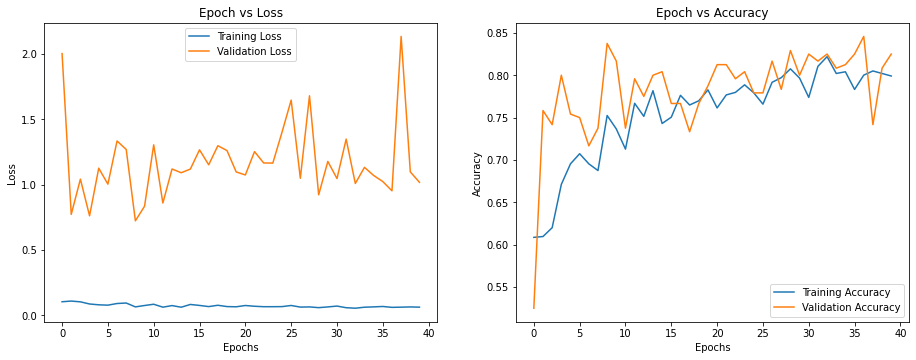

In [ ]:
plot_loss_accuracy(resnet_18_pretrained_rmsprop_train_loss, resnet_18_pretrained_rmsprop_train_acc, resnet_18_pretrained_rmsprop_val_loss, resnet_18_pretrained_rmsprop_val_acc)

Test accuracy is  85.546875


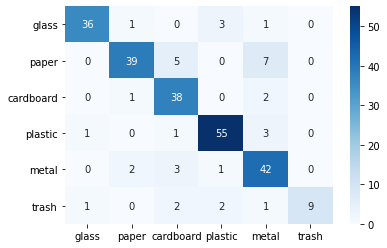

In [ ]:
total = 0.0
correct = 0.0
y_test = []
y_pred = []
with torch.no_grad():
  for data, target in test_data_loader:
      data, target = data.to(device), target.to(device)
      output = resnet_18_pretrained(data)
      
      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
      y_test.extend(target.cpu().detach().numpy())
      y_pred.extend(predicted.cpu().detach().numpy())
print('Test accuracy is ', correct*100/total)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=WASTE_DICT_REV.values(), yticklabels=WASTE_DICT_REV.values())

# Result

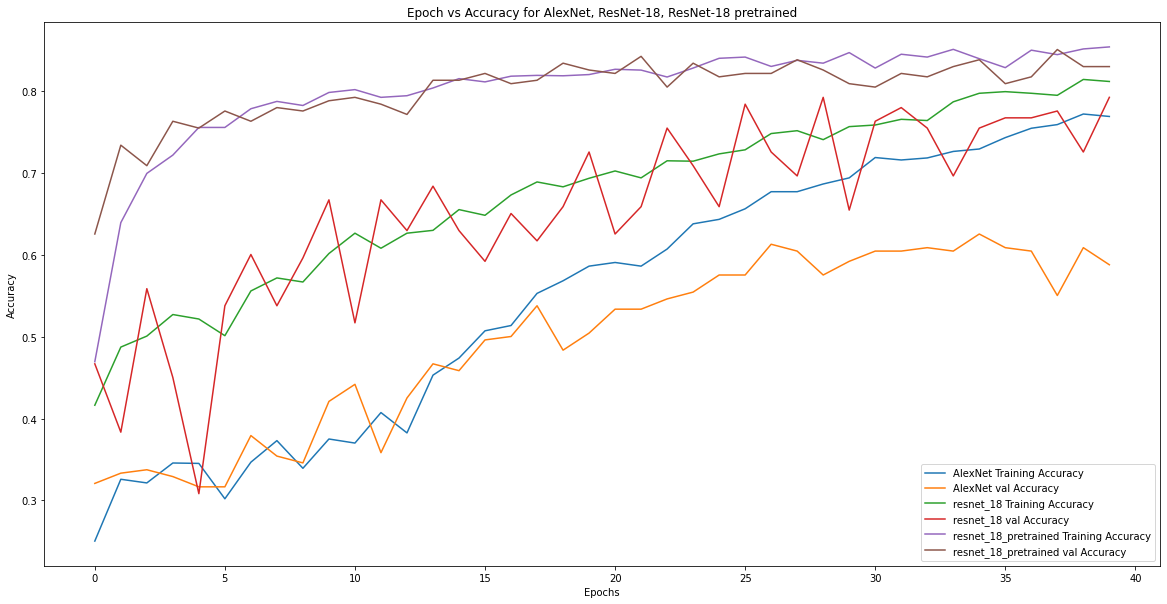

In [ ]:
epochs = len(alex_train_acc)

plt.figure(figsize=(20,10))
plt.plot(list(range(epochs)), alex_train_acc, label='AlexNet Training Accuracy')
plt.plot(list(range(epochs)), alex_val_acc, label='AlexNet val Accuracy')
plt.plot(list(range(epochs)), resnet_18_train_acc, label='resnet_18 Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_val_acc, label='resnet_18 val Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_train_acc, label='resnet_18_pretrained Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_val_acc, label='resnet_18_pretrained val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy for AlexNet, ResNet-18, ResNet-18 pretrained')
plt.legend()
plt.show()


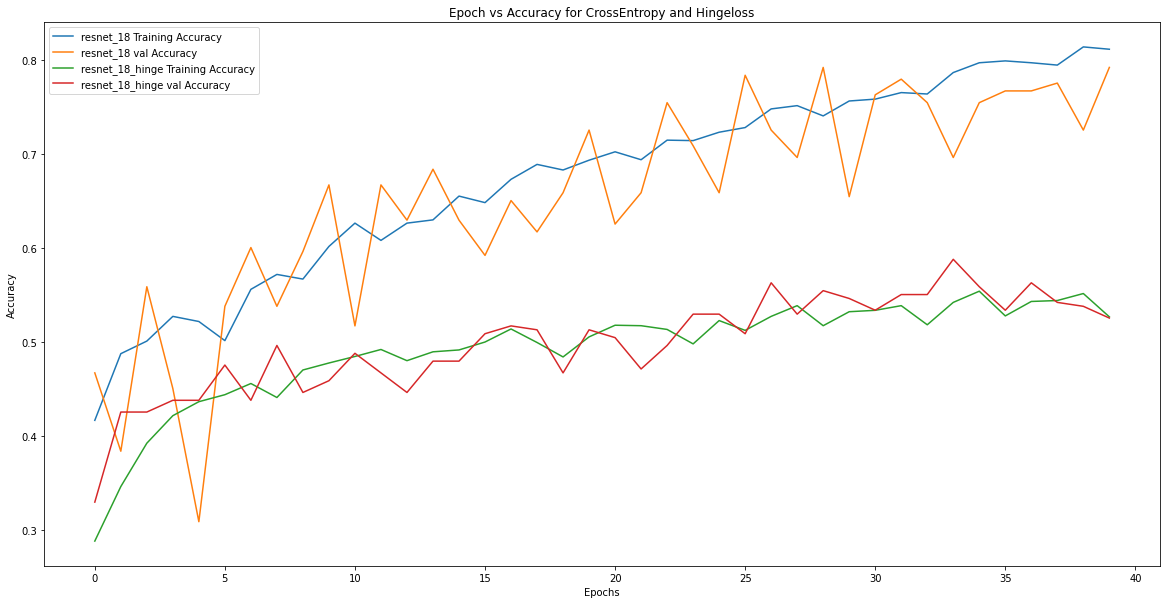

In [ ]:
epochs = len(alex_train_acc)

plt.figure(figsize=(20,10))
plt.plot(list(range(epochs)), resnet_18_train_acc, label='resnet_18 Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_val_acc, label='resnet_18 val Accuracy')
plt.plot(list(range(epochs)), resnet_18_hinge_train_acc, label='resnet_18_hinge Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_hinge_val_acc, label='resnet_18_hinge val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy for CrossEntropy and Hingeloss')
plt.legend()
plt.show()


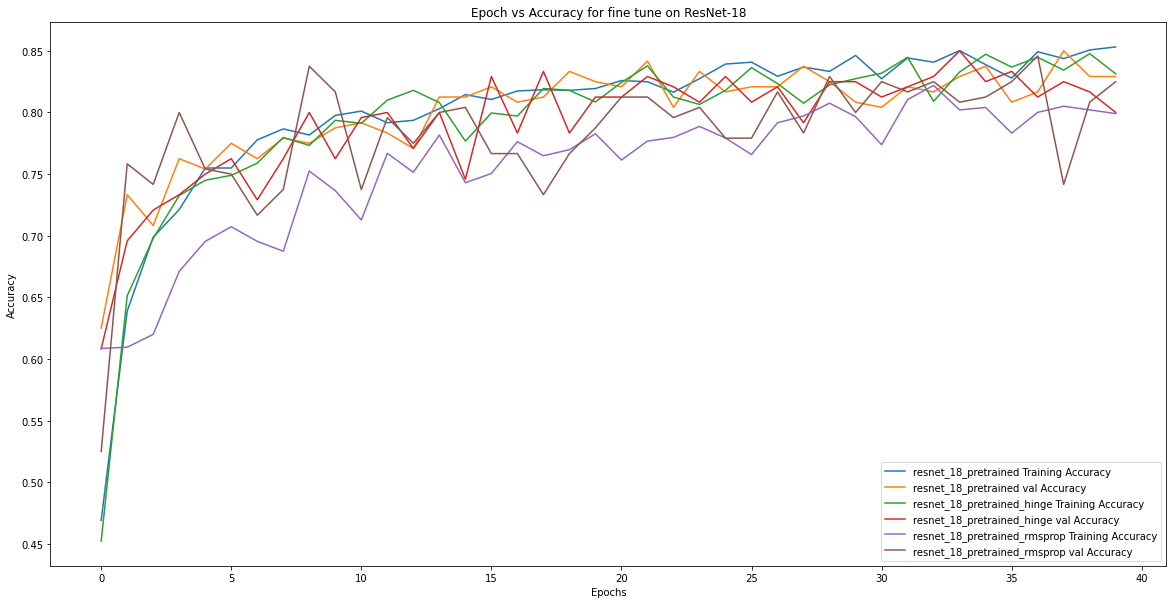

In [ ]:
epochs = len(alex_train_acc)

plt.figure(figsize=(20,10))
plt.plot(list(range(epochs)), resnet_18_pretrained_train_acc, label='resnet_18_pretrained Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_val_acc, label='resnet_18_pretrained val Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_hinge_train_acc, label='resnet_18_pretrained_hinge Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_hinge_val_acc, label='resnet_18_pretrained_hinge val Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_rmsprop_train_acc, label='resnet_18_pretrained_rmsprop Training Accuracy')
plt.plot(list(range(epochs)), resnet_18_pretrained_rmsprop_val_acc, label='resnet_18_pretrained_rmsprop val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy for fine tune on ResNet-18')
plt.legend()
plt.show()
